In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.special import erf
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# faz a leitura do ficheiro de dados localizado no github

url = 'https://raw.githubusercontent.com/Miguel-Salgado/covid-19/master/obitos-e-casos-confirmados-de-cov.csv'
df = pd.read_csv(url,error_bad_lines=False)
#df = df[(df.T != 0).all()]
df.head(80)


,Dia_do_Ano,Dia,Confirmados,Obitos
0,60,1,0,0
1,61,2,2,0
2,62,3,4,0
3,63,4,6,0
4,64,5,9,0
...,...,...,...,...
57,117,58,24017,928
58,118,59,24322,948
59,119,60,24505,973
60,120,61,25045,989


In [3]:
# define as funções utilizadas nos modelos

def logistic_model(x,a,b,c):
    return c/(np.exp((b-x)/a)+1)

def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def log_logistic_model(x,a,b,c):
    return c/(1+np.power((x/a),-b))

def error_function_model(x,a,b,c,d):
    return a*(1+erf((x-b)/c))-d






In [4]:
x = list(df.iloc[:,1])
y = list(df.iloc[:,2])

#print(x,y)

# utiliza curve_fit para fazer o ajuste dos dados, calculando os parâmetros a,b,c

logistic_fit = curve_fit(logistic_model,x,y,p0=[6,37,24000])

param_a_logistic = logistic_fit[0][0]
param_b_logistic = logistic_fit[0][1]
param_c_logistic = logistic_fit[0][2]
 
print("Logistic model: a = % 5.2f; b = % 5.2f; c = % 5.2f" %(param_a_logistic, param_b_logistic, param_c_logistic))    

#log_logistic_fit = curve_fit(log_logistic_model,x,y,p0=[1,200,12000],bounds=(0, [9999999., 9999999., 9999999.]))

#param_a_log_logistic = log_logistic_fit[0][0]
#param_b_log_logistic = log_logistic_fit[0][1]
#param_c_log_logistic = log_logistic_fit[0][2]

#print("Log-Logistic model: a = % 5.2f; b = % 5.2f; c = % 5.2f" %(param_a_log_logistic, param_b_log_logistic, param_c_log_logistic))

erf_fit = curve_fit(error_function_model,x,y,p0=[12500,37,17,355])

param_a_erf = erf_fit[0][0]
param_b_erf = erf_fit[0][1]
param_c_erf = erf_fit[0][2]
param_d_erf = erf_fit[0][3]

print("Error function model: a = % 5.2f; b = % 5.2f; c = % 5.2f; d = % 5.2f" %(param_a_erf, param_b_erf, param_c_erf, param_d_erf))



Logistic model: a =  7.22; b =  38.35; c =  25237.70
Error function model: a =  12942.07; b =  38.17; c =  18.06; d =  445.34


In [5]:
# calcula o erro associado ao ajuste efetuado 

errors_logistic = [np.sqrt(logistic_fit[1][i][i]) for i in [0,1,2]]

y_pred_logistic = [logistic_model(i,param_a_logistic,param_b_logistic,param_c_logistic) for i in x]

#errors_log_logistic = [np.sqrt(log_logistic_fit[1][i][i]) for i in [0,1,2]]

#y_pred_log_logistic = [log_logistic_model(i,param_a_log_logistic,param_b_log_logistic,param_c_log_logistic) for i in x]

errors_erf = [np.sqrt(erf_fit[1][i][i]) for i in [0,1,2,3]]

y_pred_erf = [error_function_model(i,param_a_erf,param_b_erf,param_c_erf,param_d_erf) for i in x]


In [6]:
# calcula a data final da infeção resolvendo a equação associada ao modelo

sol_logistic = int(fsolve(lambda x : logistic_model(x,param_a_logistic,param_b_logistic,param_c_logistic) - int(param_c_logistic),param_b_logistic))
end_date_logistic = datetime(2020, 1, 1) + timedelta(days=sol_logistic)

                              

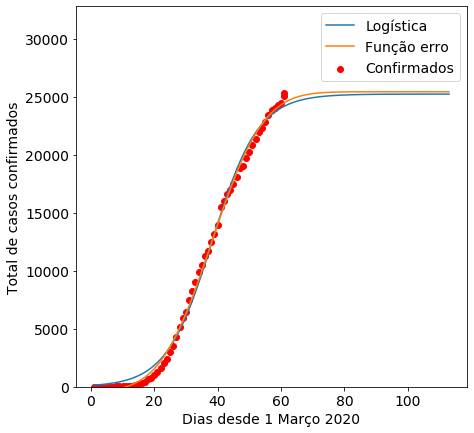

Erro quadrado médio do ajuste: 334673 (modelo logístico)
Erro quadrado médio do ajuste: 165075 (modelo função erro)
* * * * * * * * * * * * * * * * 
Previsão do número total de casos confirmados: 25237 +/- 322 (modelo logístico)


In [7]:
# constrói o gráfico e mostra os resultados das predições

pred_x = list(range(max(x),sol_logistic))

plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)

# Real data
plt.scatter(x,y,label="Confirmados",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,param_a_logistic,param_b_logistic,param_c_logistic) for i in x+pred_x], label="Logística" )

# Predicted log-logistic curve
#plt.plot(x+pred_x, [log_logistic_model(i,param_a_log_logistic,param_b_log_logistic,param_c_log_logistic) for i in x+pred_x], label="Log-Logística" )

# Predicted error function curve
plt.plot(x+pred_x, [error_function_model(i,param_a_erf,param_b_erf,param_c_erf,param_d_erf) for i in x+pred_x], label="Função erro" )

plt.legend()
plt.xlabel("Dias desde 1 Março 2020")
plt.ylabel("Total de casos confirmados")
plt.ylim((min(y)*0.9,param_c_logistic*1.3))
plt.show()


print("Erro quadrado médio do ajuste: %1d (modelo logístico)" %mean_squared_error(y,y_pred_logistic))
#print("Erro quadrado médio do ajuste: %1d (modelo log-logístico)" %mean_squared_error(y,y_pred_log_logistic))
print("Erro quadrado médio do ajuste: %1d (modelo função erro)" %mean_squared_error(y,y_pred_erf))
print("* * * * * * * * * * * * * * * * ")
print("Previsão do número total de casos confirmados: %2d +/- %2d (modelo logístico)" %(param_c_logistic, errors_logistic[2]))
#print("Previsão do número total de óbitos: %2d +/- %2d (modelo log-logístico)" %(param_c_log_logistic, errors_log_logistic[2]))
#print("Previsão do número total de óbitos: %2d +/- %2d (modelo função erro)" %(param_d_erf, errors_erf[0]))
#print("* * * * * * * * * * * * * * * * ")
#print("Previsão do final da infeção: %d/%d/%d (modelo logístico)" %(end_date_logistic.day, end_date_logistic.month, end_date_logistic.year))